# Anomaly Detection

## 1. Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

---

## 2. Problem Statement

- We are given 3 numpy.ndarray **(X_train, X_val, y_val)**
- We first need to train the Anomaly Detection Algorithm on **X_train** to find outliers.

    

---

## 3. Dataset

In [2]:
X_train = np.load("data/X.npy")
X_val = np.load("data/X_val.npy")
y_val = np.load("data/y_val.npy")

In [32]:
print('------------------- Training Set----------------------')
print("Shape of the X_train is: ", X_train.shape)
print('\n------------------- Validation Set----------------------')
print("Shape of the X_val is: ", X_val.shape)
print("Shape of the y_val is: ", y_val.shape)
print('\n------------------- Observation----------------------')
print("No. of Training Examples: ",X_train.shape[0])
print("No. of Features: ",X_train.shape[1])

------------------- Training Set----------------------
Shape of the X_train is:  (1000, 11)

------------------- Validation Set----------------------
Shape of the X_val is:  (100, 11)
Shape of the y_val is:  (100,)

------------------- Observation----------------------
No. of Training Examples:  1000
No. of Features:  11


### 3.1 Visualizing your data

Text(0.5, 1.0, 'The plt between First two features')

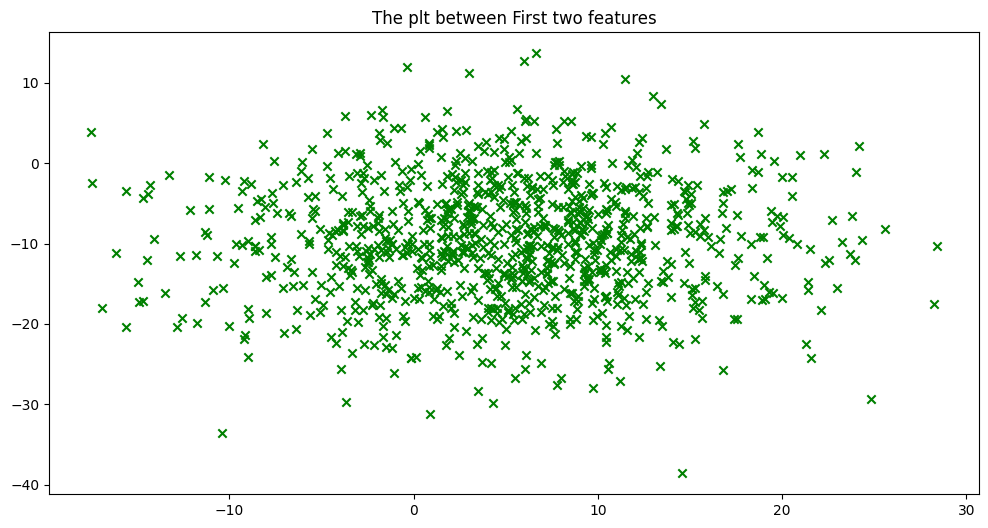

In [33]:
matplotlib.rcParams['figure.figsize'] = (12,6) 
plt.scatter(X_train[:,0], X_train[:,1], marker='x', c='g')
plt.title("The plt between First two features")



Text(0.5, 1.0, 'The plt between Second and Third feature')

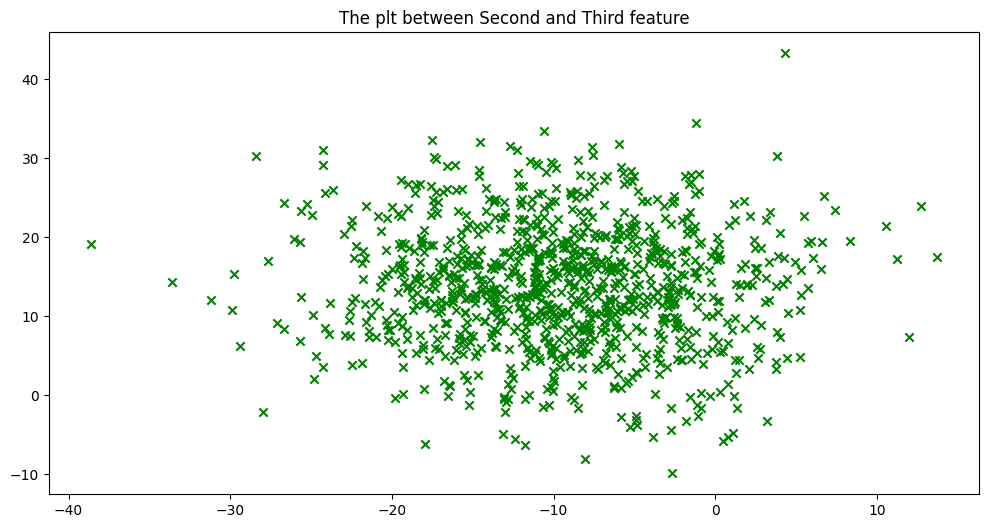

In [34]:
plt.scatter(X_train[:,1], X_train[:,2], marker='x', c='g')

plt.title("The plt between Second and Third feature")


---

## 4. Building the Model

To perform Anomaly detection, we will make use of Gaussian Distribution to calculate **Probability Density Function** which is given as,
 $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$
- This gives the probabilty if the given input is an outlier or not.
    - If  $ p(x ; \mu,\sigma ^2)$ < $\varepsilon$, Its an outlier 
    - If  $ p(x ; \mu,\sigma ^2)$ > $\varepsilon$, Its ok 

### 4.1 Estimating paramters ($\mu_i$, $\sigma_i^2$)

These two parameters are used ($\mu_i$, $\sigma_i^2$) in the above given formula,

For Mean $\mu_i$:
$$\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$
For Variance $\sigma_i^2$:
$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

Here,
- Features are represented by, $i = 1\ldots n$
- Training examples are represented by, $j = 1\ldots m$

In [35]:
def estimate_gaussian_parameters(X):
    
    m,n = X.shape
    mu = np.zeros(n)
    var = np.zeros(n)
    sum = np.zeros(n)
    sub = np.zeros(n)

    for i in range(n):
        for j in range(m):
            sum[i] += X[j][i]
    
    mu = sum/m

    for i in range(n):
        for j in range(m):
            sub[i] += (X[j][i] - mu[i])**2
    
    var = sub/m

    return mu, var

### 4.2 Compute Probability Density function: $p(x ; \mu,\sigma ^2)$

The formula to compute PDF is as, For single feature:
 $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

- We already got the values of $\mu_i$ and $\sigma_i^2$ from `estimate_gaussian_parameter()` Function

Similarly for multiple features:

<img src="Formula.jpg">

In [37]:
def multivariate_gaussian(X, mu, var):
    """
    Computes the probability density function of the examples X 
    under the multivariate gaussian  distribution with parameters mu and var.
    If var is a matrix, it is treated as the covariance matrix.
    If var is a vector, it is treated as the var values of the 
    variances in each dimension (a diagonal covariance matrix)
    """
    k = len(mu)                                                 # length of mu(number of dimensions in the distribution.)

    if var.ndim == 1:                                            # If var is 1 dim array, it converts var into a diagonal matrix using np.diag
        var = np.diag(var)
    
    X = X - mu

    p = (2* np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * \
        np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))  
    
    '''
    p is a numpy array of the same length as X, containing the probabilities of each element of X under the given multivariate Gaussian distribution.
    '''

    return p

### 4.3 Selecing Threshold $\epsilon$

$\epsilon$ is used to compare with $ p(x ; \mu,\sigma ^2)$, to estimate if the probability is anomaly or not

- This gives the probabilty if the given input is an outlier or not.
    - If  $ p(x ; \mu,\sigma ^2)$ < $\varepsilon$, Its an outlier 
    - If  $ p(x ; \mu,\sigma ^2)$ > $\varepsilon$, Its ok 

- The value of $\epsilon$ is chosen based on the $F_1$ score, i.e.the $\epsilon$ with the highest $F_1$ score is selected.
$$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}$$ 
Where, 
- The $F_1$ score is computed using precision ($prec$) and recall ($rec$)
- $tp$ is the number of true positives
- $fp$ is the number of false positives
- $fn$ is the number of false negatives

In [40]:
def select_threshold(y_val, p_val):

    best_epsilon = 0
    best_F1 = 0
    F1 = 0

    step_size = (max(p_val) - min(p_val))/1000

    for epsilon in np.arange(min(p_val), max(p_val), step_size):

        tp = 0
        fp = 0
        fn = 0
        prec = 0
        rec = 0

        p_val_temp = np.zeros(p_val.shape)

        for i in range(len(p_val)):
            if(p_val[i] < epsilon):
                p_val_temp[i] = 1
            else:
                p_val_temp[i] = 0

        for i in range(len(p_val_temp)):
            if( p_val_temp[i] == 1 and y_val[i] == 1):
                tp += 1
            
            elif( p_val_temp[i] == 1 and y_val[i] == 0):
                fp += 1
            
            elif( p_val_temp[i] == 0 and y_val[i] == 1):
                fn += 1
        
        if(tp+fp == 0):
            prec = 0
            rec = 0
            F1 = 0
        else:
            prec = tp/(tp+fp)
            rec = tp/(tp+fn)
            F1 = (2*prec*rec)/(prec+rec)

        
        if (F1 > best_F1):
            best_F1 = F1
            best_epsilon = epsilon
    
    return best_epsilon, best_F1

In [44]:
mu, var = estimate_gaussian_parameters(X_train)

# For Validation Set
p_val = multivariate_gaussian(X_val, mu, var)

#For Training Set
p_train = multivariate_gaussian(X_train, mu, var)

epsilon, F1 = select_threshold(y_val, p_val)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)
print('Anomalies found: %d'% sum(p_train < epsilon))


Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set: 0.615385
Anomalies found: 117


---

<img src="Intuition.jpg">

<img src="Algorithm.jpg">